In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir + '/pinns'), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

We will solve the folloving problem: given $x_0$ and $v_0$, find such $x(t): \mathbb{R} \to \mathbb{R}$, so that

$$\frac{\mathrm{d}^2 x}{\mathrm{d}t^2} + \zeta \omega_{0} \frac{\mathrm{d}x}{\mathrm{d}t} + \omega_{0}^{2}x = 0$$
$$x(0) = x_{0}, \frac{\mathrm{d}x}{\mathrm{d}t}(0) = v_{0}$$

Parameters $\zeta$ and $\omega_{0}$ are a physical parameters that characterize oscillation and it's damping.

In [3]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

Let's solve this problem numerically so we can measure actual error of our model.

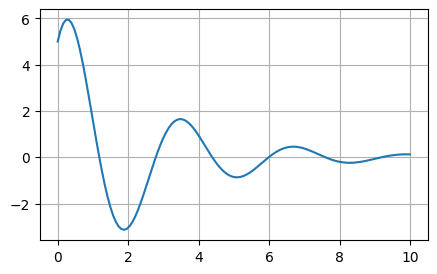

In [4]:
from scipy.integrate import solve_ivp

def dho(t, y, zeta, omega):
    x, v = y
    dxdt = v
    dvdt = -2 * zeta * omega * v - omega**2 * x
    return [dxdt, dvdt]

T = 10              # We need to fix some computational domain.
p = (0.2, 2.0)      # Parameters that yields interesting function.
x0, v0 = 5.0, 7.0   # Initial values may be arbitrary.

t = torch.linspace(0, T, 128)
solution = solve_ivp(dho, (0, T), (x0, v0), t_eval=t, args=p).y[0]

fig = plt.figure(figsize=(5, 3))
plt.plot(t, solution)
plt.grid()
plt.show()

Now we need to define all basic building blocks that will be used to train our model.

First of all, we need to build all of ours samplers. We can use predefined samplers if their signature satisfies all of our needs. Since initial values are just numbers and not functions or large arrays, it is reasonable to use ConstantSampler logic. For collocation points, we might choose RandomSampler. For test points, let's use ConstantSampler.

If you want, for example, load data from disk or sample it from some function, or make signatures easier, you should define your own sampler. Also you can always redefine training logic and make your own Trainer, if it is really necessary (and it should not be so hard).

In [27]:
from pinns.samplers import ConstantSampler, RandomSampler

# Constraints (training data) sampler must return tuple (points, values).
constraints_sampler = ConstantSampler((
    torch.tensor([[0.]], requires_grad=True),
    torch.tensor([x0, v0])
))

# Collocation sampler must return just tensor of shape [num_pts, coords].
domain_range = [0, T]
collocation_sampler = RandomSampler(domain_range, (256, 1))

# Test points sampler must return tuple (points, values) of shape [num_pts, coords].
test_points_sampler = ConstantSampler(
    (t.reshape(-1, 1), solution.reshape(-1, 1))
    )

Now we want to define loss function. For differentiation, let's use function d from our derivatives collection.

Remember that internal logic of training must be consistent with sampler output and way in what model makes predictions.

In [10]:
from pinns.derivatives import d

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    zeta = 0.2, omega = 2.0
    ):
    
    def init_loss(x0, t0):
        v0 = d(x0, t0)
        return torch.mean(torch.square(torch.hstack([x0, v0]) - cstr_vals))

    def ode_loss(x, t):
        v = d(x, t)
        a = d(v, t)
        return torch.mean(torch.square(a + 2 * zeta * omega * v + omega**2 * x))
    
    losses = (
        init_loss(cstr_pred, cstr_pts),
        ode_loss(coll_pred, coll_pts)
    )
    
    return losses

And now we can define some neural network and train it using default training logic.

In [7]:
from pinns import Trainer
from pinns.models import FF
from pinns.optimizers import Adam

pinn = FF([1] + [64, 64] + [1], activ=nn.Tanh(), biases=True)
print(f'Model has {pinn.count_parameters()} trainable parameters.')

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2],    # Coefficients are very important.
    test_points_sampler=test_points_sampler
)

trainer.train(
    num_iters=1000,
    optimizers=[(0, adam)]
    )

Model has 146 trainable parameters.


And we can measure actual error:

In [58]:
from pinns.errors import l2_error
print(f'L2 error of model is {trainer.evaluate(l2_error):.5f}')

L2 error of model is 5.22516


It depends on particular case, whether it is good value or not. Usually we expect 0.01 and lower.

Let's plot results.

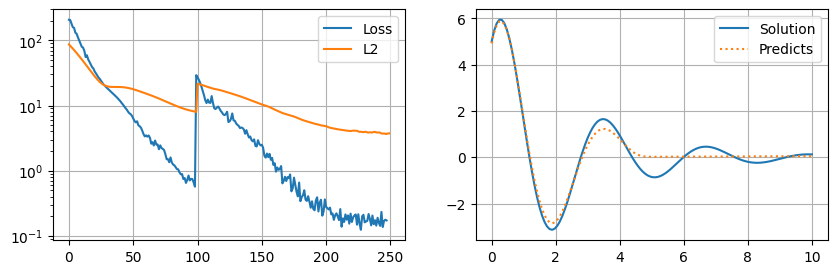

In [12]:
# pinn.model = torch.load('./very_good_model_dont_delete.pt')

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(trainer.loss_history, label='Loss')
axs[0].plot(range(0, trainer.iter, 1), trainer.error_history, label='L2')
axs[0].grid()
axs[0].set_yscale('log')
axs[0].legend()

preds = pinn.predict(t.reshape(-1, 1))
axs[1].plot(t, solution, label='Solution')
axs[1].plot(t, preds.detach(), label='Predicts', linestyle=':')
axs[1].grid()
axs[1].legend()

plt.show()

In [11]:
# trainer.model.model.plot()